# Visualizing ridge and lasso linear regression in 2 dimensions

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Draw ellipses
# Equation: lambda |X beta - Y|^2 = r^2 
# X must be shape (2, 2) and Y shape (2,)
# Note: if X has one nonzero eigenvalue, then there will be an extra line in the graph which should be ignored
def draw_ellipse(ax, X=np.eye(2), Y=np.zeros(2), r=1, lam=1, resolution=0.00001):
    # If lambda is non-positive, there are no solutions
    if lam <= 0:
        return np.array([]), np.array([])

    # If X = 0, then everything is a solution.  Return everything in the range [-a, a] x [-a, a]
    if (X == 0).prod() == 1:
        a = resolution * 100
        x = np.arange(-a*100, a*100 + resolution, resolution)
        y = np.arange(-a, a + resolution, resolution)
        x, y = np.tile(x, (1, y.shape[0])).flatten(), np.tile(y, (x.shape[0], 1)).swapaxes(0,1).flatten()
        ax.plot(x, y)
        return x, y

    # If X is nondegenerate (rank 2)
    if np.linalg.det(X).item() != 0:
        r = r / math.sqrt(lam)
        x = np.arange(-r, r  + resolution, resolution)
        y = np.sqrt(r ** 2 - x ** 2)
        x = np.concatenate([x, x[-1::-1]])
        y = np.concatenate([y, -y[-1::-1]])
        xy = np.concatenate([x[None], y[None]])
        xy = np.linalg.inv(X) @ (xy + Y[:, None])
        ax.plot(xy[0], xy[1])
        return xy[0], xy[1]
    
    # If X has rank 1
    else:
        u, sigma, vh = np.linalg.svd(X)
        # The formula is (sigma f1 V^T * beta - f1 U^T Y)^2 + (f2 * U^T Y)^2 = r^2/lambda, where f_i are the standard row vectors
        r = math.sqrt(r ** 2 /lam  - (u.T @ Y)[1] ** 2)
        if r < 0:
            return np.array([]), np.array([])
        # Rewrite formula: f * beta = a +- r
        a = (u.T @ Y)[0]
        f = sigma[0] * vh[0]
        # If f is vertical, handle it separately (default to interval [-5, 5])
        if f[1] == 0:
            x = np.concatenate([np.full((2,), (a + r)/f[0]), np.full((2,), (a - r)/f[0])])
            y = np.array([-1, 1, 1, -1])
            ax.axline((x[0], y[0]), (x[1], y[1]))
            ax.axline((x[2], y[2]), (x[3], y[3]))
            return x, y
        else:
            x = np.array([-1, 1, 1, -1])
            y1 = (a + r - f[0] * x[:x.shape[0]//2]) / f[1]
            y2 = (a - r - f[0] * x[x.shape[0]//2:]) / f[1]
            y = np.concatenate([y1, y2])
            ax.axline((x[0], y[0]), (x[1], y[1]))
            ax.axline((x[2], y[2]), (x[3], y[3]))
            return x, y



# Draw diamonds centered at 0
# Equation: lam * |beta| = r
def draw_rhombus(ax, r, lam=1, resolution=0.00001):
    r = r / math.sqrt(lam)
    x = np.arange(-r, r + resolution, resolution)
    y = r - np.abs(x)
    x, y = np.concatenate([x,x[-1::-1]]), np.concatenate([y, -y[-1::-1]])
    ax.plot(x, y)
    return x, y


def step_grad_ridge(X, Y, lam, beta0, step):
    return beta0 - step * (2 * X.T @ (X @ beta0 - Y) + 2 * lam * beta0)

# Two methods for doing gradient descent:
## 1. Proximal gradient descent snaps the point to the coordinate axes once they pass a proximity threshold.  We implement this by blocking wall crossings.
## 2. Subgradient descent samples some number of points in the interval [-1, 1] as candidates for the gradient at singular points, then chooses the one that minimizes the loss function.
## This allows wall crossings.  We approximate this by setting the derivative of the L1 part at a singular point to 0.
def step_grad_lasso(X, Y, lam, beta0, step, method='proximal'):
    beta = beta0 - step * (2 * X.T @ (X @ beta0 - Y) + lam * np.sign(beta0))
    if method == 'subgradient':
        return beta
    else:   # Default is proximal
        return (((beta > 0) & (beta0 > 0)) | ((beta < 0) & (beta0 < 0))) * beta
    


# Closed form solution for ridge regression
def solve_beta_ridge(X, Y, lam):
    return np.linalg.inv(X.T @ X + lam * np.eye(2)) @ X.T @ Y

# Lasso regression solved by some kind of gradient descent
def solve_beta_lasso(X, Y, lam, start=None, step=0.01, steps=1000, ax=None, method='proximal'):
    if start == None:
        start = [Y]
    elif type(start) != list:
        start = [start]
    
    betas = []
    for s in start:
        for i in range(steps):
            if ax != None:
                ax.plot(*s.tolist(), marker='o', markersize='1', color='green')
            s = step_grad_lasso(X, Y, lam, s, step, method=method)
        betas.append(s)
    return betas


def draw_ridge(ax, X, Y, lam, start=None, step=0.01, steps=1000):
    if start is None:
        start = [Y]
    elif type(start) != list:
        start = [start]
    
    ax.set_aspect(1)
    ax.axvline(x=0, color='black')
    ax.axhline(y=0, color='black')

    beta = solve_beta_ridge(X, Y, lam)

    fr = np.linalg.norm(X @ beta - Y)
    gr = math.sqrt(lam) * np.linalg.norm(beta)

    draw_ellipse(ax, X=X, Y=Y, r=fr)
    draw_ellipse(ax, r=gr, lam=lam)

    for s in start:
        for i in range(steps):
            ax.plot(*s.tolist(), marker='o', markersize='1', color='green')
            s = step_grad_ridge(X, Y, lam, s, step=step)

    ax.plot(*beta, marker='o', color='red')


def draw_lasso(ax, X, Y, lam, start = None, step=0.01, steps=1000, method='proximal'):
    if start is None:
        start = [Y]
    elif type(start) != list:
        start = [start]
    
    ax.set_aspect(1)
    ax.axvline(x=0, color='black')
    ax.axhline(y=0, color='black')

    # This is a list, make it an array
    betas = np.concatenate([b[None] for b in solve_beta_lasso(X, Y, lam, start=start, step=step, steps=steps, ax=ax, method=method)])

    # Prune the list
    keep = np.full((betas.shape[0],), True)
    for i in range(betas.shape[0]):
        for j in range(i - 1):
            if np.linalg.norm(betas[i] - betas[j]) < step:
                keep[i] = 0
                break
    betas = betas[keep]

    for i in range(betas.shape[0]):
        beta = betas[i]

        fr = np.linalg.norm(X @ beta - Y)
        gr = math.sqrt(lam) * np.abs(beta).sum()

        draw_ellipse(ax, X=X, Y=Y, r=fr)
        draw_rhombus(ax, r=gr, lam=lam)
        ax.plot(*beta, marker='o', color='red')

/tmp/ipykernel_606615/1844106599.py:27: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(r ** 2 - x ** 2)


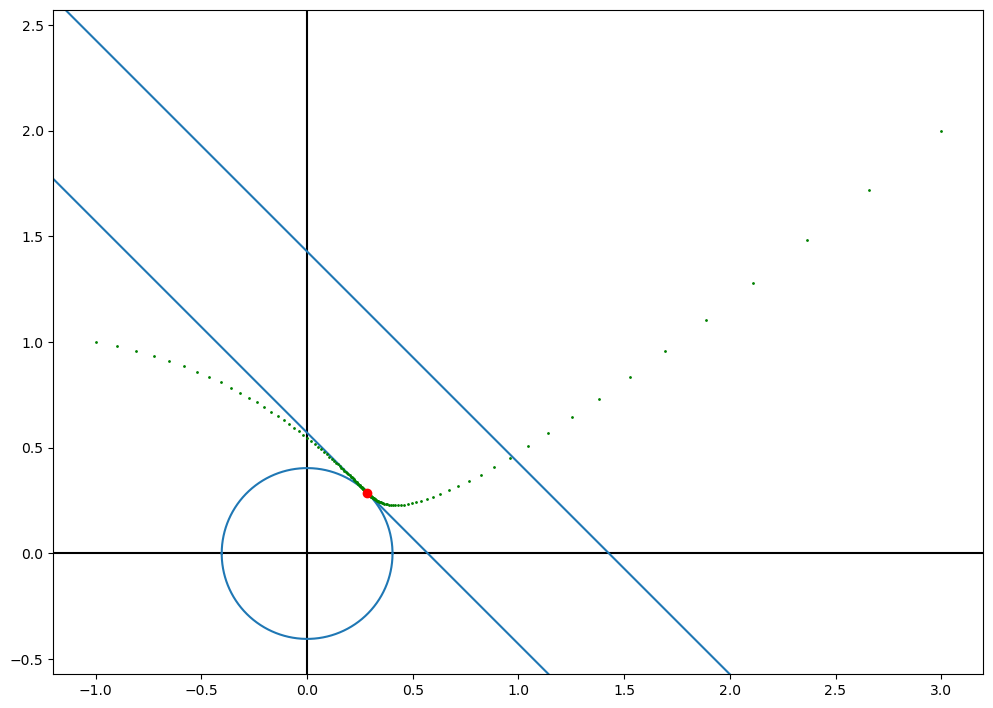

In [3]:
X = np.diag([0, 1])
X = np.full((2,2), 1)
Y = np.array([1,1])


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

draw_ridge(ax, X, Y, lam=3, start=[np.array([3,2]), np.array([-1, 1])])

/tmp/ipykernel_606615/1844106599.py:27: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(r ** 2 - x ** 2)


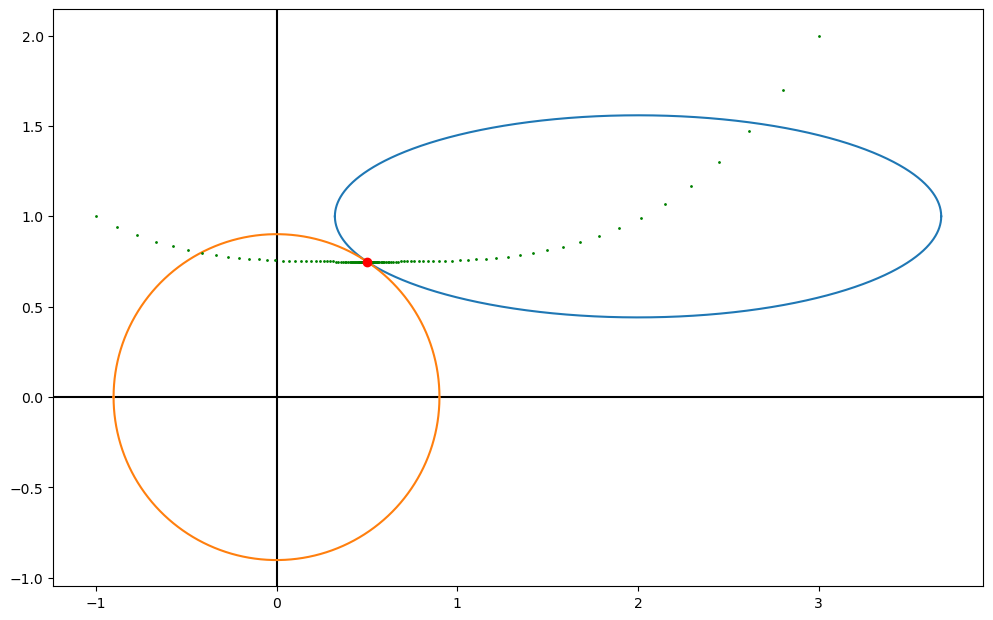

In [4]:
X = np.diag([1,3])
Y = np.array([2,3])
            
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

draw_ridge(ax, X, Y, lam=3, start=[np.array([3,2]), np.array([-1, 1])])

/tmp/ipykernel_608211/1844106599.py:27: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(r ** 2 - x ** 2)


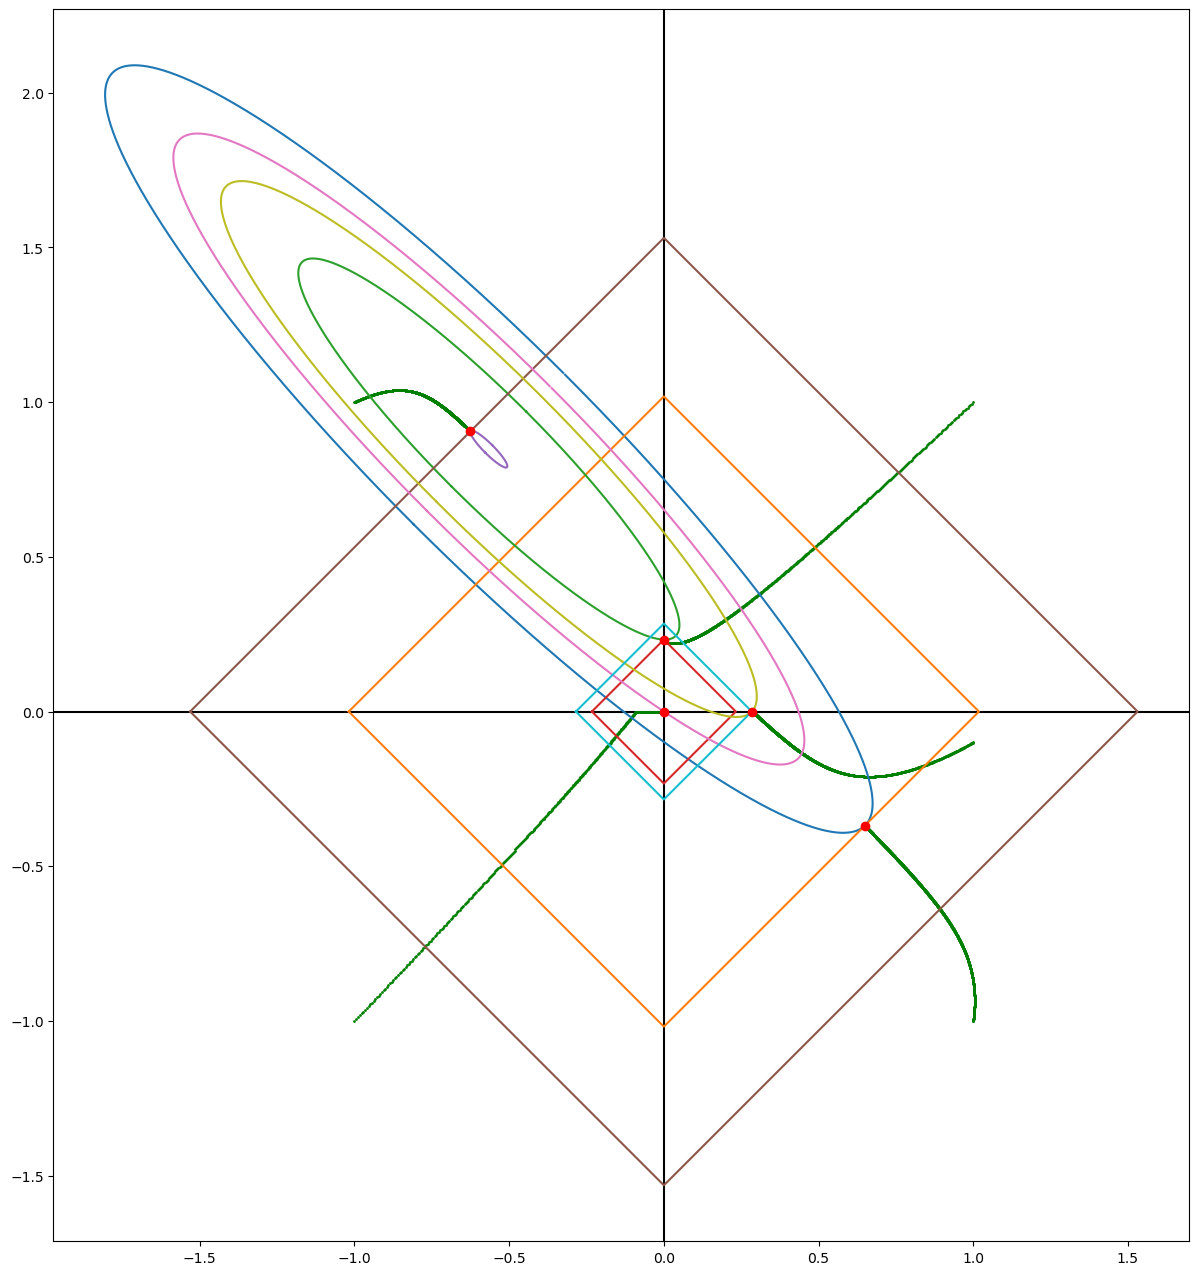

In [2]:
V = np.eye(2)
Sigma = np.array([[5,0],[0,1]])
U = np.array([[1,-1],[1,1]]) / math.sqrt(2)
X = V @ Sigma @ U.T
Y = np.array([1,1])
lam = 2

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot()
draw_lasso(ax, X, Y, lam, start=[np.array([1, -1]), np.array([1,1]), np.array([-1,1]), np.array([-1,-1]), np.array([1, -.1])], step=0.0001, steps=1000, method='proximal')


/tmp/ipykernel_606615/1844106599.py:27: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(r ** 2 - x ** 2)


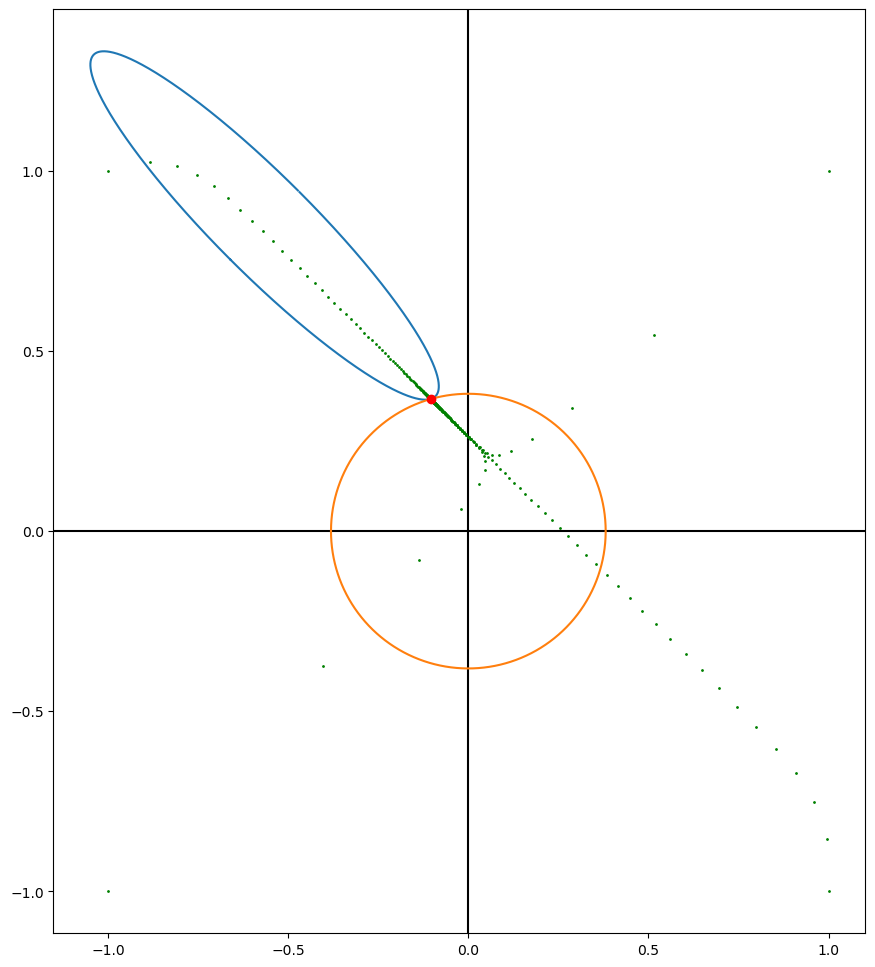

In [6]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

start = [np.array([1,1]), np.array([-1,1]), np.array([1,-1]), np.array([-1,-1])]

draw_ridge(ax, X, Y, lam, start=start)